https://langchain-ai.github.io/langgraph/tutorials/introduction/
# Introduction to LangGraph
## Part 1: Build a Basic Chatbot

In [2]:
import os
openai_api_key = os.getenv('OPENAI_API_KEY')
tavily_api_key = os.getenv('TAVILY_API_KEY')

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [6]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [12]:
graph_builder.set_entry_point("chatbot")

In [13]:
graph_builder.set_finish_point("chatbot")

In [14]:
graph = graph_builder.compile()

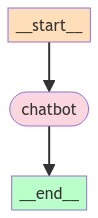

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Langgraph is a tool that helps language learners track their progress, set goals, and stay motivated on their language learning journey. Users can input their daily study habits, track their vocabulary and grammar progress, and receive personalized recommendations for improvement. Langgraph also offers a community feature where users can connect with other language learners to share tips and resources. The goal of Langgraph is to make language learning more enjoyable and effective for users of all levels.
Assistant: I apologize for any confusion. Can you please provide more context or clarify your statement so I can better understand and assist you?
Goodbye!


## Part 2: Enhancing the Chatbot with Tools

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
# Their TOOL
tool_Tavily = TavilySearchResults(max_results=2)
# MY TOOL
@tool
def identify_exchange_market(url: str) -> str:
    """
    This function checks the input URL and returns the corresponding exchange name in Chinese.
    Parameters:
    url (str): The URL to be checked.
    Returns:
    str: The name of the exchange in Chinese.
    """
    if "sse.com.cn" in url:
        return "上海交易所"
    elif "szse.cn" in url:
        return "深圳交易所"
    elif "sgx.com" in url:
        return "新加坡交易所"
    elif "hkexnews.hk" in url:
        return "香港交易所"
    else:
        return "no match is found"  # Return "Unknown Exchange" if no match is found

tools = [tool_Tavily, identify_exchange_market]
tool_Tavily.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'},
 {'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'}]

In [20]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [22]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}  # prebuilt ToolNode (from langgraph.prebuilt import ToolNode, tools_condition)

#tool_node = ToolNode(tools=[tool])
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [23]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__" # prebuilt tools_condition (from langgraph.prebuilt import ToolNode, tools_condition)


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools, # tools_condition
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

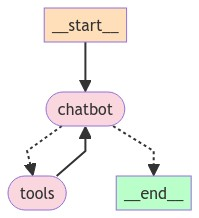

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs using regular python functions or JS. Learn how to create graphs with nodes, edges, state, tools, and conditional edges for agentic behaviors."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures ..."}]
Assistant: LangGraph is a library for building stateful, multi-actor applications with LLMs (Large Language Models) using regular Python functions or JavaScript. It allows users to create graphs with nodes, edges, state, tools, and conditional edges for agentic behaviors. 

Y

## Part 3: Adding Memory to the Chatbot

In [27]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [28]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [29]:
graph = graph_builder.compile(checkpointer=memory)

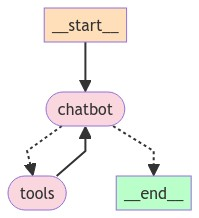

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
config = {"configurable": {"thread_id": "1"}} # Where the history of the conversation is stored

In [32]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [38]:
user_input = "What is my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Will. How can I assist you today, Will?


In [39]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I'm afraid I don't have access to personal information like your name. If you'd like to share your name with me again, feel free to do so! How can I assist you today?


## Part 4: Human-in-the-loop

In [51]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = SqliteSaver.from_conn_string(":memory:")


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool_Tavily = TavilySearchResults(max_results=2)
tools = [tool_Tavily, identify_exchange_market]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [52]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [53]:
user_input = "This is an report(https://www.avisbudgetgroup.com/wp-content/uploads/2024/01/ESG-REPORT-2023_01-08-2024.pdf) issued by an exchange market\
help me identify the exchange market"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

This is an report(https://www.avisbudgetgroup.com/wp-content/uploads/2024/01/ESG-REPORT-2023_01-08-2024.pdf) issued by an exchange markethelp me identify the exchange market
================================== Ai Message ==================================
Tool Calls:
  identify_exchange_market (call_AxCTfqmP3QBXYSdT7XSktUf1)
 Call ID: call_AxCTfqmP3QBXYSdT7XSktUf1
  Args:
    url: https://www.avisbudgetgroup.com/wp-content/uploads/2024/01/ESG-REPORT-2023_01-08-2024.pdf


In [54]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [55]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'identify_exchange_market',
  'args': {'url': 'https://www.avisbudgetgroup.com/wp-content/uploads/2024/01/ESG-REPORT-2023_01-08-2024.pdf'},
  'id': 'call_AxCTfqmP3QBXYSdT7XSktUf1'}]

In [56]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: identify_exchange_market

no match is found
================================== Ai Message ==================================

I couldn't identify the exchange market from the provided report. If you have any other information or details about the exchange market, please let me know so I can assist you further.


## Part 5: Manually Updating the State

In [57]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool_Tavily = TavilySearchResults(max_results=2)
tools = [tool_Tavily, identify_exchange_market]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [58]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_C6IaKZVGqqQQsbZjsxRHkFWb)
 Call ID: call_C6IaKZVGqqQQsbZjsxRHkFWb
  Args:
    query: LangGraph


In [66]:
from langchain_core.messages import AIMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='ca1202ad-5a8c-4e39-b394-9165e767b84a', tool_call_id='call_C6IaKZVGqqQQsbZjsxRHkFWb'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a546693c-03f2-43fd-8cec-9835b75080e7')]


In [67]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef32cab-6ef4-6f44-8005-3ed6fa6e540d'}}

In [68]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='ca1202ad-5a8c-4e39-b394-9165e767b84a', tool_call_id='call_C6IaKZVGqqQQsbZjsxRHkFWb'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a546693c-03f2-43fd-8cec-9835b75080e7'), AIMessage(content="I'm an AI expert!", id='18fa55c3-9d44-4a2c-b7bd-16ddfbc4b014')]
()


### Add Messages

In [69]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_RZIFnsRXZ8l2Gqk7746NP1mD)
 Call ID: call_RZIFnsRXZ8l2Gqk7746NP1mD
  Args:
    query: LangGraph


In [70]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-38d7d561-e16d-480e-b80a-13a4ffb23927-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_RZIFnsRXZ8l2Gqk7746NP1mD'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_RZIFnsRXZ8l2Gqk7746NP1mD'}
Message ID run-38d7d561-e16d-480e-b80a-13a4ffb23927-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_RZIFnsRXZ8l2Gqk7746NP1mD'}]

In [71]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/how-tos/human-in-the-loop/", "content": "How to add human-in-the-loop. When creating LangGraph agents, it is often nice to add a human-in-the-loop component. This can be helpful when giving them access to tools. Often in these situations you may want to manually approve an action before taking. This can be in several ways, but the primary supported way is to add an \"interrupt\" before ..."}, {"url": "https://langchain-ai.github.io/langgraph/concepts/low_level/", "content": "At its core, LangGraph models agent workflows as graphs. You define the behavior of your agents using three key components: ... First, it allows for human-in-the-loop workflows, as it allows humans to inspect, interrupt, and approve steps. Checkpointers are needed for these workflows as the human has to be able to view the state of a graph at ..."}]
==

In [72]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

You're learning about LangGraph and its human-in-the-loop workflow.


## Part 6: Customizing State

In [73]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [74]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [75]:
tool_Tavily = TavilySearchResults(max_results=2)
tools = [tool_Tavily, identify_exchange_market]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [76]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [77]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [78]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

In [79]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

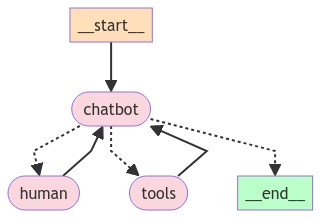

In [80]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [81]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_txFw27t0gymo1xHV73i8diGg)
 Call ID: call_txFw27t0gymo1xHV73i8diGg
  Args:
    request: I need expert guidance for building an AI agent. Can you provide assistance?


In [82]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [83]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef32cc4-5b00-6b46-8002-35370be983f2'}}

In [84]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='801869c4-c47b-4931-9ba3-04fcd27c82c0'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_txFw27t0gymo1xHV73i8diGg', 'function': {'arguments': '{"request":"I need expert guidance for building an AI agent. Can you provide assistance?"}', 'name': 'RequestAssistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 225, 'total_tokens': 254}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-84eecfa8-767c-4158-91bb-1f776e618f27-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need expert guidance for building an AI agent. Can you provide assistance?'}, 'id': 'call_txFw27t0gymo1xHV73i8diGg'}], usage_metadata={'input_tokens': 225, 'output_tokens': 29, 'total_tokens': 254}),
 ToolMessage(content="We, the expert

In [85]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts have suggested using LangGraph to build your AI agent as it is more reliable and extensible than simple autonomous agents. This platform can provide you with the necessary tools and guidance to create a robust AI agent.


## Part 7: Time Travel

In [18]:
from typing import Annotated, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool_Tavily = TavilySearchResults(max_results=2)
tools = [tool_Tavily, identify_exchange_market]
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

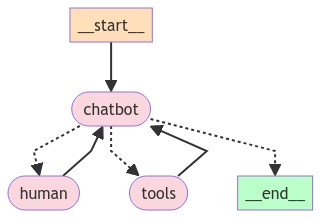

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_CHkykxBbOD7a1xJA0P8sBtdP)
 Call ID: call_CHkykxBbOD7a1xJA0P8sBtdP
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG-based solutions."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": 

In [21]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Help me build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Help me build an autonomous agent with it!
================================== Ai Message ==================================

Building an autonomous agent with LangGraph involves defining workflows and interactions between multiple actors. Here's a general outline of the steps to create an autonomous agent using LangGraph:

1. **Define Actors**: Identify the actors that will be part of your autonomous agent system. Actors can represent different components or entities that interact within the system.

2. **Define Workflows**: Define the workflows or sequences of actions that each actor will perform. These workflows will determine the behavior and interactions of the autonomous agent.

3. **Implement Logic**: Use LangGraph to implement the logic for each actor and the interactions between them. LangGraph provides the framework for building stateful, multi-actor applications with LLMs.

4.

In [24]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [25]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'thread_ts': '1ef32cda-e850-6ee0-8006-8d0f3241dde8'}}


In [26]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

ValueError: No tasks to run in graph.